# Final Emission Refector Testing
Testing final (for now) corrections to how the emission model and emission are dealt with in the context of producing emission in each channel of the detector.

In [60]:
import os
import subprocess
import sys
import urllib

from IPython.display import HTML
import numpy as np
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sunpy.map import Map
from scipy.interpolate import interp1d
import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_tools_util

import synthesizAR
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import EbtelInterface,calculate_free_energy
from synthesizAR.instruments import InstrumentHinodeEIS,InstrumentSDOAIA

%matplotlib inline

In [2]:
ar_root = '/data/datadrive2/ar_viz/final_emiss_refactor_testing/'

## Field and Loop Simulations

In [ ]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2013_01_01_07_35_15_tai_magnetogram.0.fits',
                             crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(100,loop_length_range=[1e+9,1e+11]*u.cm)

In [ ]:
field.make_loops()

In [ ]:
class NanoflareStormModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        np.random.seed()
        
    @property
    def number_events(self):
        return 1
    
    def calculate_event_properties(self,loop):
        available_energy = calculate_free_energy(loop.field_aligned_coordinate,loop.field_strength,
                                                 stress_level=self.heating_options['stress_level'])
        rate = 2.0*available_energy/(self.number_events*(2.0*self.heating_options['duration'] 
                                                         - self.heating_options['duration_rise'] 
                                                         - self.heating_options['duration_decay']))
        #distribute start times randomly between 0 and total_time - duration
        tsr = np.random.rand(self.number_events)*(self.base_config['total_time'] - self.heating_options['duration'])
        ter = tsr + self.heating_options['duration_rise']
        tsd = ter + (self.heating_options['duration'] 
                     - self.heating_options['duration_rise'] 
                     - self.heating_options['duration_decay'])
        ted = tsr + self.heating_options['duration']
        return {'magnitude':np.array([rate]),'rise_start':tsr,'rise_end':ter,'decay_start':tsd,'decay_end':ted}

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
}
heating_model = NanoflareStormModel(heating_options)
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model,
                            os.path.join(ar_root,'hydro_config'),
                            os.path.join(ar_root,'hydro_results'))

In [ ]:
field.configure_loop_simulations(ebtel_plug)

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

In [4]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-03-06 18:01:11,908 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-06 18:01:11,909 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-03-06 18:01:11,910 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2017-03-06 18:01:11,911 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2017-03-06 18:01:11,912 Parameters: cosmological_simulation   = 0.0


## Emission
Restore the emission model from our previous work.

In [3]:
emiss_model = EmissionModel.restore('/data/datadrive2/ar_viz/seminar_poc/checkpoint_emiss_model/')

Fe VI psplups file not found
Fe VIII psplups file not found
Fe XVI psplups file not found
Fe XVII psplups file not found
Fe XXIV psplups file not found
Fe XXV psplups file not found


In [ ]:
field.calculate_fractional_ionization(emiss_model,
                                      interface=ebtel_plug,
                                      savefile=os.path.join(ar_root,'nei_populations.h5'),
                                     nei_solver_options={'cutoff':1e-6})

Next calculate the emission. Note that we only calculate the emission for those transitions which we resolve in wavelength space.

In [ ]:
field.calculate_emission(emiss_model,savefile=os.path.join(ar_root,'loop_emiss.h5'))

Save the field again.

In [ ]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

## Observe
Now declare the instrument classes and make the observations. Note that we have to give the emission model to the AIA instrument class if we aren't using the temperature response function method.

In [5]:
eis = InstrumentHinodeEIS([0,4990]*u.s)
aia = InstrumentSDOAIA([0,4990]*u.s,use_temperature_response_functions=False,emission_model=emiss_model)

In [6]:
observer = synthesizAR.Observer(field,[aia,eis],ds=field._convert_angle_to_length(0.3*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [7]:
observer.build_detector_files(ar_root)

In [ ]:
observer.flatten_detector_counts()

In [ ]:
observer.make_temperature_map(3500*u.s,aia).peek()

In [8]:
observer.bin_detector_counts(ar_root)

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


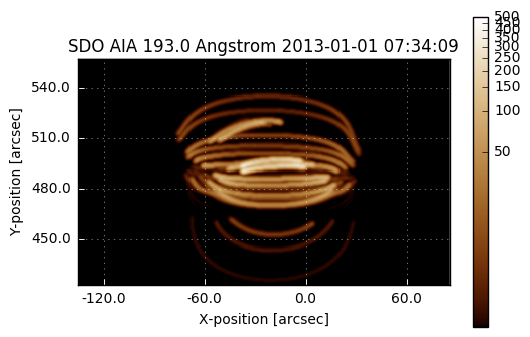

In [35]:
Map(os.path.join(ar_root,'SDO_AIA/193/map_t000410.fits')).peek(vmin=0.1,vmax=500)

In [52]:
cube = synthesizAR.util.EISCube(os.path.join(ar_root,'Hinode_EIS/170-210/map_t000100.fits'))

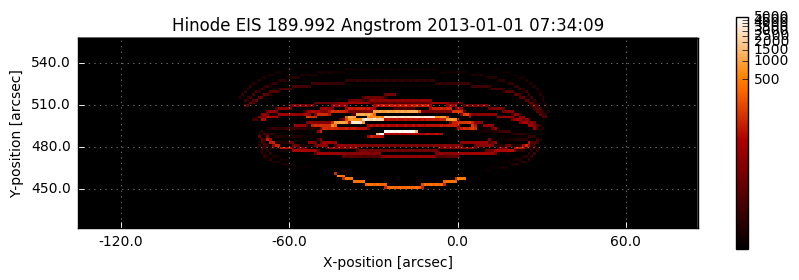

In [53]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(projection=cube.integrated_intensity)
im = cube.integrated_intensity.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1e-3,vmin=1,vmax=5000))
fig.colorbar(im)

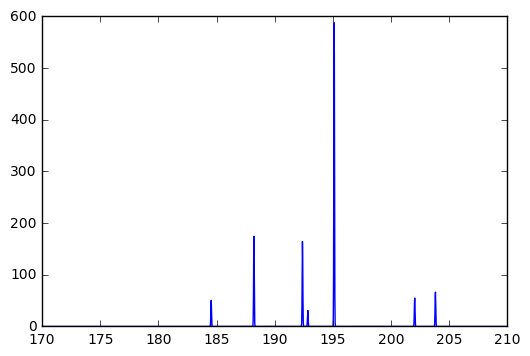

In [55]:
plt.plot(cube.wavelength,np.mean(cube.data[:,100,:],axis=0))

## Spectrum Animation

In [68]:
np.where(np.logical_and(cube.wavelength.value>191,cube.wavelength.value<194))

(array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]),)

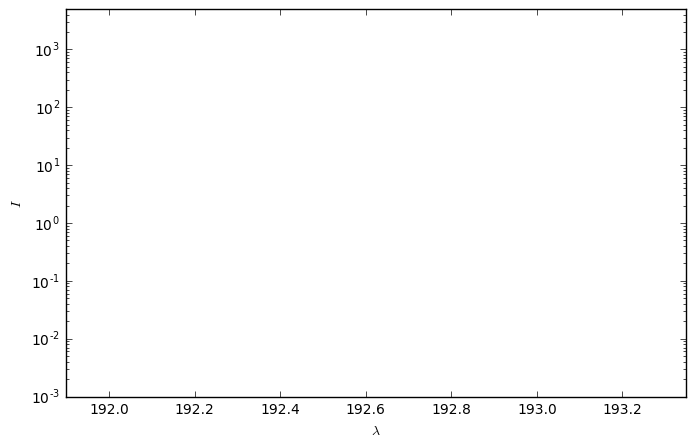

In [79]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
line, = ax.plot([],[],lw=2,color=sns.color_palette('deep')[0])
ax.set_xlim([cube.wavelength[91].value,cube.wavelength[156].value])
ax.set_ylim([1e-3,5000])
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$I$')
time_text = ax.text(0.1,0.9,'',transform=ax.transAxes)
def init():
    line.set_data([],[])
    time_text.set_text('')
    return line,time_text
def animate(i):
    filename = os.path.join(ar_root,'Hinode_EIS/170-210/map_t{:06d}.fits'.format(i))
    cube = synthesizAR.util.EISCube(filename)[91:157]
    line.set_data(cube.wavelength.value,
                 np.mean(cube.data[:,100,:],axis=0))
    time_text.set_text(r'$t={}$ s'.format(eis.observing_time.value[i]))
    return line,time_text

In [80]:
anim = matplotlib.animation.FuncAnimation(fig,
                                          animate,
                                          init_func=init,
                                          frames=489,
                                          interval=100,
                                          blit=True)

In [81]:
HTML(anim.to_html5_video())